In [256]:
def parse_vrp(file_path):
    vrp_data = {
        "capacity": None,
        "dimension": None,
        "node_coordinates": [],
        "demands": {},
        "number_of_vehicles": None 
    }
    
    with open(file_path, 'r') as file:
        lines = file.readlines()

    section = None
    for line in lines:
        line = line.strip()
        
        if line.startswith("EDGE_WEIGHT_SECTION"):
            return []
        
        if "COMMENT" in line and 'trucks' in line:
            parts = line.split(',')
            for part in parts:
                if 'trucks' in part:
                    vrp_data["number_of_vehicles"] = int(part.split(':')[1].strip())
        
        elif line.startswith("CAPACITY"):
            vrp_data["capacity"] = int(line.split(":")[1].strip())
        elif line.startswith("DIMENSION"):
            vrp_data["dimension"] = int(line.split(":")[1].strip())
        elif line == "NODE_COORD_SECTION":
            section = "NODE_COORD_SECTION"
        elif line == "DEMAND_SECTION":
            section = "DEMAND_SECTION"
            continue
        elif line in ["DEPOT_SECTION", "EOF"]:
            section = None
            continue
        
        elif section == "NODE_COORD_SECTION" and line:
            node_id, x, y = map(int, line.split())
            vrp_data["node_coordinates"].append((node_id, x, y))
        elif section == "DEMAND_SECTION" and line:
            node_id, demand = map(int, line.split())
            vrp_data["demands"][node_id] = demand
    
    return vrp_data

def get_optimal(file_path):
    with open(file_path, 'r') as file:
        for last_line in file:
            pass
    
    return int(last_line.split()[-1])

def calculate_gap(heur_cost, optimal_cost):
    gap = ((heur_cost - optimal_cost) / optimal_cost) * 100
    return gap

def list_files(directory):
    files = []
    for entry in os.listdir(directory):
        full_path = os.path.join(directory, entry)
        if os.path.isfile(full_path):
            files.append(entry)
    return files

In [289]:
vrp_data = parse_vrp('./A/A-n32-k5.vrp')
vrp_data

{'capacity': 100,
 'dimension': 32,
 'node_coordinates': [(1, 82, 76),
  (2, 96, 44),
  (3, 50, 5),
  (4, 49, 8),
  (5, 13, 7),
  (6, 29, 89),
  (7, 58, 30),
  (8, 84, 39),
  (9, 14, 24),
  (10, 2, 39),
  (11, 3, 82),
  (12, 5, 10),
  (13, 98, 52),
  (14, 84, 25),
  (15, 61, 59),
  (16, 1, 65),
  (17, 88, 51),
  (18, 91, 2),
  (19, 19, 32),
  (20, 93, 3),
  (21, 50, 93),
  (22, 98, 14),
  (23, 5, 42),
  (24, 42, 9),
  (25, 61, 62),
  (26, 9, 97),
  (27, 80, 55),
  (28, 57, 69),
  (29, 23, 15),
  (30, 20, 70),
  (31, 85, 60),
  (32, 98, 5)],
 'demands': {1: 0,
  2: 19,
  3: 21,
  4: 6,
  5: 19,
  6: 7,
  7: 12,
  8: 16,
  9: 6,
  10: 16,
  11: 8,
  12: 14,
  13: 21,
  14: 16,
  15: 3,
  16: 22,
  17: 18,
  18: 19,
  19: 1,
  20: 24,
  21: 8,
  22: 12,
  23: 4,
  24: 8,
  25: 24,
  26: 24,
  27: 2,
  28: 20,
  29: 15,
  30: 2,
  31: 14,
  32: 9},
 'number_of_vehicles': 5}

In [295]:
import random
import math

def calculate_distance(node1, node2, node_coordinates):
    x1, y1 = node_coordinates[node1][1:]
    x2, y2 = node_coordinates[node2][1:]
    return math.hypot(x2 - x1, y2 - y1)


def calculate_route_distance(route, node_coordinates):
    if len(route) == 0:
        return 0
    
    distance = 0
    for i in range(1, len(route)):
        distance += calculate_distance(route[i - 1], route[i], node_coordinates)

    distance += calculate_distance(0, route[0], node_coordinates) + calculate_distance(route[-1], 0, node_coordinates)
    return distance


def get_obj_val(solution, node_coordinates):
    return sum(calculate_route_distance(route, node_coordinates) for route in solution)


def get_initial_solution(node_coordinates, demands, vehicle_capacity, number_of_vehicles):
    nodes = list(range(1, len(node_coordinates)))
    random.shuffle(nodes)

    routes = [[] for _ in range(number_of_vehicles)]
    capacities = [vehicle_capacity] * number_of_vehicles
    
    for node in nodes:
        for i in range(number_of_vehicles):
            if capacities[i] >= demands[node]:
                routes[i].append(node)
                capacities[i] -= demands[node]
                break
    return routes


def swap_nodes(solution, demands):
    """Swapping nodes within a single route"""
    new_solution = [route[:] for route in solution]
    
    route_index = random.randint(0, len(solution) - 1)
    if len(solution[route_index]) > 1:
        i, j = random.sample(range(len(solution[route_index])), 2)
        new_solution[route_index][i], new_solution[route_index][j] = new_solution[route_index][j], new_solution[route_index][i]
    
    return new_solution


def swap_nodes_v2(solution, demands, vehicle_capacity):
    """Swapping nodes between two routes"""
    new_solution = [route[:] for route in solution]
    route_count = len(new_solution)

    route1_idx, route2_idx = random.sample(range(route_count), 2)

    if not new_solution[route1_idx] or not new_solution[route2_idx]:
        return solution

    node1_idx = random.randrange(len(new_solution[route1_idx]))
    node2_idx = random.randrange(len(new_solution[route2_idx]))
    node1 = new_solution[route1_idx][node1_idx]
    node2 = new_solution[route2_idx][node2_idx]

    cap1_after_swap = sum(demands[node] for i, node in enumerate(new_solution[route1_idx]) if i != node1_idx) + demands[node2]
    cap2_after_swap = sum(demands[node] for i, node in enumerate(new_solution[route2_idx]) if i != node2_idx) + demands[node1]

    if cap1_after_swap <= vehicle_capacity and cap2_after_swap <= vehicle_capacity:
        new_solution[route1_idx][node1_idx], new_solution[route2_idx][node2_idx] = node2, node1
        return new_solution
    else:
        return solution


def simulated_annealing(node_coordinates, demands, vehicle_capacity, number_of_vehicles, initial_temp, 
                        cooling_rate,
                        min_temp, current_solution=None):
    if not current_solution:
        current_solution = get_initial_solution(node_coordinates, demands, vehicle_capacity, number_of_vehicles)
    
    current_obj_val = get_obj_val(current_solution, node_coordinates)
    temperature = initial_temp

    while temperature > min_temp:
#         new_solution = swap_nodes(current_solution, demands)
        new_solution = swap_nodes_v2(current_solution, demands, vehicle_capacity)
        new_obj_val = get_obj_val(new_solution, node_coordinates)

        if new_obj_val < current_obj_val or random.random() < math.exp((current_obj_val - new_obj_val) / temperature):
            current_solution = new_solution
            current_obj_val = new_obj_val

        temperature *= cooling_rate

    return current_solution, current_obj_val

In [198]:
import os
initial_temp = 10000
cooling_rate = 0.995
min_temp = 0.01
files = list_files('./A')
files = [file for file in files if '.vrp' in file]

gaps = []

for file in files:
    vrp_data = parse_vrp('./A/' + file)
    node_coordinates = vrp_data['node_coordinates']
    demands = vrp_data['demands']
    vehicle_capacity = vrp_data['capacity']
    number_of_vehicles = vrp_data['number_of_vehicles']
    solution, cost = simulated_annealing(node_coordinates, demands, vehicle_capacity, number_of_vehicles, initial_temp, cooling_rate, min_temp)
    opt_val = get_optimal('./A/' + file[:-3] + 'sol')
    gap = calculate_gap(cost, opt_val)
    print("Total Distance:", cost, " optimal cost: ", opt_val, " gap: ", gap)
    gaps.append(gap)
#     print(solution, '\n')
print('avg gap:', sum(gaps) / len(gaps))

Total Distance: 3353.0008742755117  optimal cost:  1763  gap:  90.18723053179306
Total Distance: 1713.9972570466236  optimal cost:  1034  gap:  65.76375793487657
Total Distance: 2521.645242404406  optimal cost:  1616  gap:  56.04240361413403
Total Distance: 1831.304580265037  optimal cost:  1073  gap:  70.67144270876393
Total Distance: 888.4591545736607  optimal cost:  661  gap:  34.411369829600716
Total Distance: 941.723195108409  optimal cost:  742  gap:  26.916872656119807
Total Distance: 1378.4646790892461  optimal cost:  669  gap:  106.04853200138209
Total Distance: 1339.959691471709  optimal cost:  949  gap:  41.19701701493245
Total Distance: 1443.605943746086  optimal cost:  914  gap:  57.94375752145362
Total Distance: 2118.80964655737  optimal cost:  1167  gap:  81.56038102462468
Total Distance: 1354.2604050367243  optimal cost:  937  gap:  44.53152668481582
Total Distance: 1309.7379930999816  optimal cost:  831  gap:  57.60986679903509
Total Distance: 1901.558330839233  optima

In [307]:
def run_all_bechmarks(initial_temp, cooling_rate, min_temp, task_type='A'):
    files = list_files('./' + task_type)
    files = [file for file in files if '.vrp' in file]

    gaps = []

    for file in files:
        vrp_data = parse_vrp('./' + task_type + '/' + file)
        if vrp_data == []:
            continue
        node_coordinates = vrp_data['node_coordinates']
        demands = vrp_data['demands']
        vehicle_capacity = vrp_data['capacity']
        number_of_vehicles = vrp_data['number_of_vehicles']
        solution, cost = simulated_annealing(node_coordinates, demands, vehicle_capacity, number_of_vehicles, initial_temp, cooling_rate, min_temp)
            
        opt_val = get_optimal('./' + task_type + '/' + file[:-3] + 'sol')
        gap = calculate_gap(cost, opt_val)
#         print("Total Distance:", cost, " optimal cost: ", opt_val, " gap: ", gap)
        gaps.append(gap)
    #     print(solution, '\n')
    return sum(gaps) / len(gaps)

In [220]:
def grid_search(initial_temp_values, cooling_rate_values, min_temp):
    best_avg_gap = float('inf')
    best_params = {}
    
    for initial_temp in initial_temp_values:
        for cooling_rate in cooling_rate_values:
            
            avg_gap = run_all_bechmarks(initial_temp, cooling_rate, min_temp)
            
            if avg_gap < best_avg_gap:
                best_avg_gap = avg_gap
                best_params = {
                    'initial_temp': initial_temp,
                    'cooling_rate': cooling_rate,
                    'min_temp': min_temp
                }
    return best_params

In [221]:
initial_temp_values = list(range(100, 10010, 100))
cooling_rate_values = [x / 1000.0 for x in range(800, 1000, 5)]

In [222]:
cooling_rate_values.append(0.999)

In [223]:
best_params = grid_search(initial_temp_values, cooling_rate_values, 0.01)
best_params

1 /4100
2 /4100
3 /4100
4 /4100
5 /4100
6 /4100
7 /4100
8 /4100
9 /4100
10 /4100
11 /4100
12 /4100
13 /4100
14 /4100
15 /4100
16 /4100
17 /4100
18 /4100
19 /4100
20 /4100
21 /4100
22 /4100
23 /4100
24 /4100
25 /4100
26 /4100
27 /4100
28 /4100
29 /4100
30 /4100
31 /4100
32 /4100
33 /4100
34 /4100
35 /4100
36 /4100
37 /4100
38 /4100
39 /4100
40 /4100
41 /4100
42 /4100
43 /4100
44 /4100
45 /4100
46 /4100
47 /4100
48 /4100
49 /4100
50 /4100
51 /4100
52 /4100
53 /4100
54 /4100
55 /4100
56 /4100
57 /4100
58 /4100
59 /4100
60 /4100
61 /4100
62 /4100
63 /4100
64 /4100
65 /4100
66 /4100
67 /4100
68 /4100
69 /4100
70 /4100
71 /4100
72 /4100
73 /4100
74 /4100
75 /4100
76 /4100
77 /4100
78 /4100
79 /4100
80 /4100
81 /4100
82 /4100
83 /4100
84 /4100
85 /4100
86 /4100
87 /4100
88 /4100
89 /4100
90 /4100
91 /4100
92 /4100
93 /4100
94 /4100
95 /4100
96 /4100
97 /4100
98 /4100
99 /4100
100 /4100
101 /4100
102 /4100
103 /4100
104 /4100
105 /4100
106 /4100
107 /4100
108 /4100
109 /4100
110 /4100
111 /410

833 /4100
834 /4100
835 /4100
836 /4100
837 /4100
838 /4100
839 /4100
840 /4100
841 /4100
842 /4100
843 /4100
844 /4100
845 /4100
846 /4100
847 /4100
848 /4100
849 /4100
850 /4100
851 /4100
852 /4100
853 /4100
854 /4100
855 /4100
856 /4100
857 /4100
858 /4100
859 /4100
860 /4100
861 /4100
862 /4100
863 /4100
864 /4100
865 /4100
866 /4100
867 /4100
868 /4100
869 /4100
870 /4100
871 /4100
872 /4100
873 /4100
874 /4100
875 /4100
876 /4100
877 /4100
878 /4100
879 /4100
880 /4100
881 /4100
882 /4100
883 /4100
884 /4100
885 /4100
886 /4100
887 /4100
888 /4100
889 /4100
890 /4100
891 /4100
892 /4100
893 /4100
894 /4100
895 /4100
896 /4100
897 /4100
898 /4100
899 /4100
900 /4100
901 /4100
902 /4100
903 /4100
904 /4100
905 /4100
906 /4100
907 /4100
908 /4100
909 /4100
910 /4100
911 /4100
912 /4100
913 /4100
914 /4100
915 /4100
916 /4100
917 /4100
918 /4100
919 /4100
920 /4100
921 /4100
922 /4100
923 /4100
924 /4100
925 /4100
926 /4100
927 /4100
928 /4100
929 /4100
930 /4100
931 /4100
932 /4100


1594 /4100
1595 /4100
1596 /4100
1597 /4100
1598 /4100
1599 /4100
1600 /4100
1601 /4100
1602 /4100
1603 /4100
1604 /4100
1605 /4100
1606 /4100
1607 /4100
1608 /4100
1609 /4100
1610 /4100
1611 /4100
1612 /4100
1613 /4100
1614 /4100
1615 /4100
1616 /4100
1617 /4100
1618 /4100
1619 /4100
1620 /4100
1621 /4100
1622 /4100
1623 /4100
1624 /4100
1625 /4100
1626 /4100
1627 /4100
1628 /4100
1629 /4100
1630 /4100
1631 /4100
1632 /4100
1633 /4100
1634 /4100
1635 /4100
1636 /4100
1637 /4100
1638 /4100
1639 /4100
1640 /4100
1641 /4100
1642 /4100
1643 /4100
1644 /4100
1645 /4100
1646 /4100
1647 /4100
1648 /4100
1649 /4100
1650 /4100
1651 /4100
1652 /4100
1653 /4100
1654 /4100
1655 /4100
1656 /4100
1657 /4100
1658 /4100
1659 /4100
1660 /4100
1661 /4100
1662 /4100
1663 /4100
1664 /4100
1665 /4100
1666 /4100
1667 /4100
1668 /4100
1669 /4100
1670 /4100
1671 /4100
1672 /4100
1673 /4100
1674 /4100
1675 /4100
1676 /4100
1677 /4100
1678 /4100
1679 /4100
1680 /4100
1681 /4100
1682 /4100
1683 /4100
1684 /4100

2344 /4100
2345 /4100
2346 /4100
2347 /4100
2348 /4100
2349 /4100
2350 /4100
2351 /4100
2352 /4100
2353 /4100
2354 /4100
2355 /4100
2356 /4100
2357 /4100
2358 /4100
2359 /4100
2360 /4100
2361 /4100
2362 /4100
2363 /4100
2364 /4100
2365 /4100
2366 /4100
2367 /4100
2368 /4100
2369 /4100
2370 /4100
2371 /4100
2372 /4100
2373 /4100
2374 /4100
2375 /4100
2376 /4100
2377 /4100
2378 /4100
2379 /4100
2380 /4100
2381 /4100
2382 /4100
2383 /4100
2384 /4100
2385 /4100
2386 /4100
2387 /4100
2388 /4100
2389 /4100
2390 /4100
2391 /4100
2392 /4100
2393 /4100
2394 /4100
2395 /4100
2396 /4100
2397 /4100
2398 /4100
2399 /4100
2400 /4100
2401 /4100
2402 /4100
2403 /4100
2404 /4100
2405 /4100
2406 /4100
2407 /4100
2408 /4100
2409 /4100
2410 /4100
2411 /4100
2412 /4100
2413 /4100
2414 /4100
2415 /4100
2416 /4100
2417 /4100
2418 /4100
2419 /4100
2420 /4100
2421 /4100
2422 /4100
2423 /4100
2424 /4100
2425 /4100
2426 /4100
2427 /4100
2428 /4100
2429 /4100
2430 /4100
2431 /4100
2432 /4100
2433 /4100
2434 /4100

3092 /4100
3093 /4100
3094 /4100
3095 /4100
3096 /4100
3097 /4100
3098 /4100
3099 /4100
3100 /4100
3101 /4100
3102 /4100
3103 /4100
3104 /4100
3105 /4100
3106 /4100
3107 /4100
3108 /4100
3109 /4100
3110 /4100
3111 /4100
3112 /4100
3113 /4100
3114 /4100
3115 /4100
3116 /4100
3117 /4100
3118 /4100
3119 /4100
3120 /4100
3121 /4100
3122 /4100
3123 /4100
3124 /4100
3125 /4100
3126 /4100
3127 /4100
3128 /4100
3129 /4100
3130 /4100
3131 /4100
3132 /4100
3133 /4100
3134 /4100
3135 /4100
3136 /4100
3137 /4100
3138 /4100
3139 /4100
3140 /4100
3141 /4100
3142 /4100
3143 /4100
3144 /4100
3145 /4100
3146 /4100
3147 /4100
3148 /4100
3149 /4100
3150 /4100
3151 /4100
3152 /4100
3153 /4100
3154 /4100
3155 /4100
3156 /4100
3157 /4100
3158 /4100
3159 /4100
3160 /4100
3161 /4100
3162 /4100
3163 /4100
3164 /4100
3165 /4100
3166 /4100
3167 /4100
3168 /4100
3169 /4100
3170 /4100
3171 /4100
3172 /4100
3173 /4100
3174 /4100
3175 /4100
3176 /4100
3177 /4100
3178 /4100
3179 /4100
3180 /4100
3181 /4100
3182 /4100

3839 /4100
3840 /4100
3841 /4100
3842 /4100
3843 /4100
3844 /4100
3845 /4100
3846 /4100
3847 /4100
3848 /4100
3849 /4100
3850 /4100
3851 /4100
3852 /4100
3853 /4100
3854 /4100
3855 /4100
3856 /4100
3857 /4100
3858 /4100
3859 /4100
3860 /4100
3861 /4100
3862 /4100
3863 /4100
3864 /4100
3865 /4100
3866 /4100
3867 /4100
3868 /4100
3869 /4100
3870 /4100
3871 /4100
3872 /4100
3873 /4100
3874 /4100
3875 /4100
3876 /4100
3877 /4100
3878 /4100
3879 /4100
3880 /4100
3881 /4100
3882 /4100
3883 /4100
3884 /4100
3885 /4100
3886 /4100
3887 /4100
3888 /4100
3889 /4100
3890 /4100
3891 /4100
3892 /4100
3893 /4100
3894 /4100
3895 /4100
3896 /4100
3897 /4100
3898 /4100
3899 /4100
3900 /4100
3901 /4100
3902 /4100
3903 /4100
3904 /4100
3905 /4100
3906 /4100
3907 /4100
3908 /4100
3909 /4100
3910 /4100
3911 /4100
3912 /4100
3913 /4100
3914 /4100
3915 /4100
3916 /4100
3917 /4100
3918 /4100
3919 /4100
3920 /4100
3921 /4100
3922 /4100
3923 /4100
3924 /4100
3925 /4100
3926 /4100
3927 /4100
3928 /4100
3929 /4100

{'initial_temp': 6200, 'cooling_rate': 0.999, 'min_temp': 0.01}

In [296]:
# Тип А
run_all_bechmarks(**best_params, task_type='A')

42.27344318157898

In [297]:
# Тип Б
run_all_bechmarks(**best_params, task_type='B')

45.959200730269686

In [298]:
# Тип Е 
run_all_bechmarks(**best_params, task_type='E')

60.621286037402115

In [306]:
run_all_bechmarks(**best_params, task_type='A')

43.33232142043243

In [266]:
# gap относительно размерности
import matplotlib.pyplot as plt

def plot_gaps_vs_dims(initial_temp, cooling_rate, min_temp, task_type='A'):
    files = list_files('./' + task_type)
    files = [file for file in files if '.vrp' in file]

    gaps = []
    dims = []

    for file in files:
        vrp_data = parse_vrp('./' + task_type + '/' + file)
        if vrp_data == []:
            continue
        node_coordinates = vrp_data['node_coordinates']
        demands = vrp_data['demands']
        vehicle_capacity = vrp_data['capacity']
        number_of_vehicles = vrp_data['number_of_vehicles']
        solution, heur_val = simulated_annealing(node_coordinates, demands, vehicle_capacity, number_of_vehicles, initial_temp, cooling_rate, min_temp)
        opt_val = get_optimal('./' + task_type + '/' + file[:-3] + 'sol')
        gap = calculate_gap(heur_val, opt_val)
        gaps.append(gap)
        dims.append(len(node_coordinates))
    
    sorted_data = sorted(zip(dims, gaps))
    dims_sorted, gaps_sorted = zip(*sorted_data)
    plt.figure()
    plt.plot(dims_sorted, gaps_sorted, marker='o', label='Gap vs Dimension')
    plt.xlabel('Dimension')
    plt.ylabel('Gap')
    plt.title(f'Gap vs Dimension for Task Type {task_type}')
    plt.grid(True)
    plt.legend()
    plt.show()

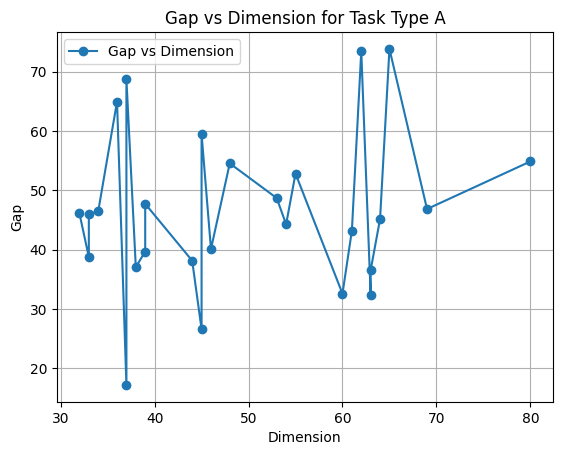

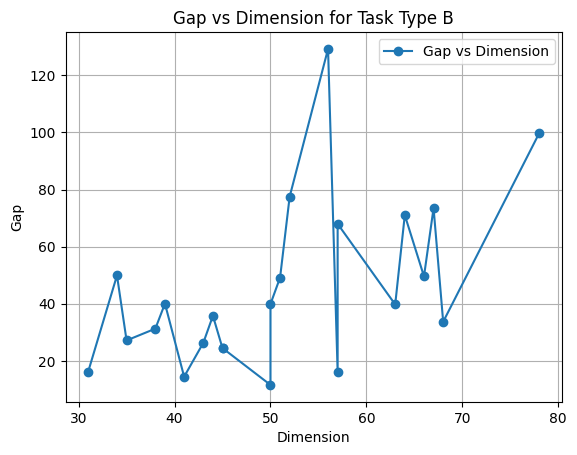

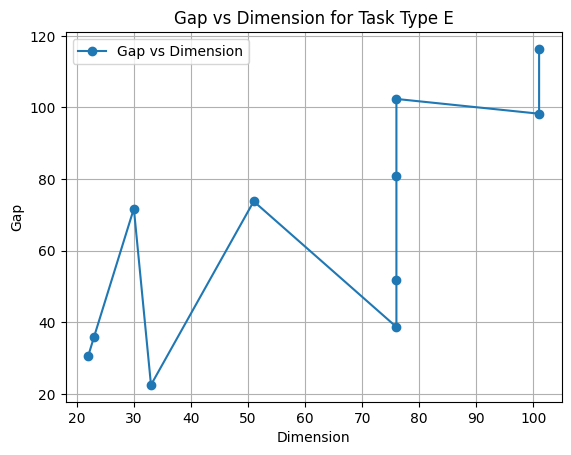

In [267]:
plot_gaps_vs_dims(**best_params)
plot_gaps_vs_dims(**best_params, task_type='B')
plot_gaps_vs_dims(**best_params, task_type='E')

In [280]:
import time

def plot_speed_vs_dim(initial_temp, cooling_rate, min_temp, task_type='A'):
    files = list_files('./' + task_type)
    files = [file for file in files if '.vrp' in file]

    times = []
    dims = []

    for file in files:
        vrp_data = parse_vrp('./' + task_type + '/' + file)
        if vrp_data == []:
            continue
        node_coordinates = vrp_data['node_coordinates']
        demands = vrp_data['demands']
        vehicle_capacity = vrp_data['capacity']
        number_of_vehicles = vrp_data['number_of_vehicles']
        
        start_time = time.time()
        solution, heur_val = simulated_annealing(node_coordinates, demands, vehicle_capacity, number_of_vehicles, initial_temp, cooling_rate, min_temp)
        end_time = time.time()
        elapsed_time = end_time - start_time
        opt_val = get_optimal('./' + task_type + '/' + file[:-3] + 'sol')
        gap = calculate_gap(heur_val, opt_val)
        times.append(elapsed_time)
        dims.append(len(node_coordinates))
    
    sorted_data = sorted(zip(times, dims))
    dims_sorted, times_sorted = zip(*sorted_data)
    plt.figure()
    plt.plot(times_sorted, dims_sorted, marker='o', label='Time vs Dimension')
    plt.ylabel('Time')
    plt.xlabel('Dimension')
    plt.title(f'Time vs Dimension for Task Type {task_type}')
    plt.grid(True)
    plt.legend()
    plt.show()

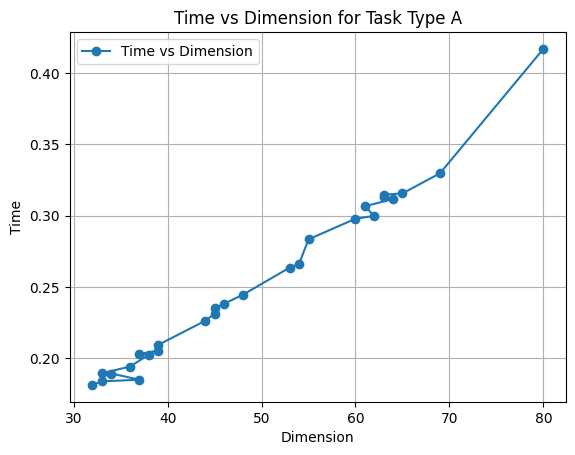

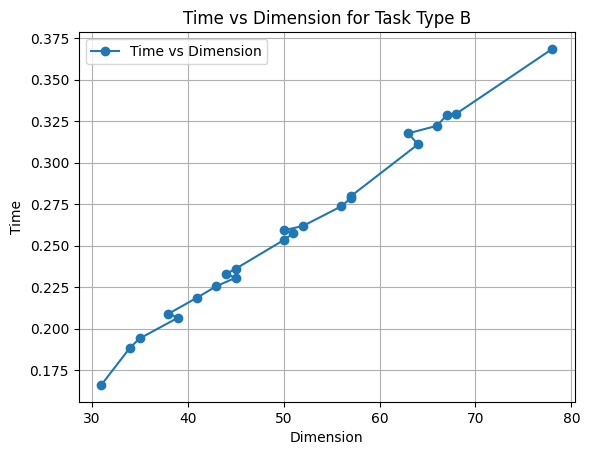

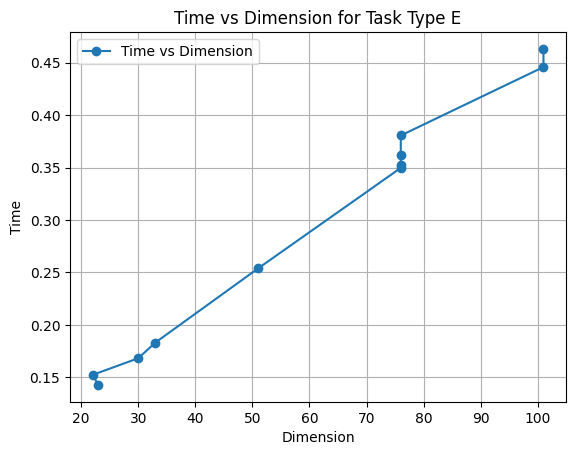

In [281]:
plot_speed_vs_dim(**best_params)
plot_speed_vs_dim(**best_params, task_type='B')
plot_speed_vs_dim(**best_params, task_type='E')

In [285]:
# Тип А
start = time.time()
run_all_bechmarks(**best_params, task_type='A')
end = time.time()
print(end - start)

6.888432025909424


In [286]:
start = time.time()
run_all_bechmarks(**best_params, task_type='B')
end = time.time()
print(end - start)

5.924843072891235


In [287]:
start = time.time()
run_all_bechmarks(**best_params, task_type='E')
end = time.time()
print(end - start)

3.2856059074401855
